In [ ]:
import numpy as np 
import pandas as pd 
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
import time
import copy
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchsummary import summary
from torchvision import datasets, transforms, models
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm
from PIL import Image
import seaborn as sns


torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## **Kaggle's Cats vs Dogs**
Download our cats vs dogs dataset. Should talk around 15-20 seconds.
Source - https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
!gdown --id 1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
!unzip -q dogs-vs-cats.zip
!unzip -q train.zip
!unzip -q test1.zip 

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Dvw0UpvItjig0JbnzbTgYKB-ibMrXdxk
To: /content/dogs-vs-cats.zip
100% 852M/852M [00:18<00:00, 46.4MB/s]


In [ ]:
# Set directory paths for our files
train_dir = './train'
test_dir = './test1'

# Get files in our directories
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [ ]:
print(f'Number of images in {train_dir} is {len(train_files)}')
print(f'Number of images in {test_dir} is {len(test_files)}')

Number of images in ./train is 25000
Number of images in ./test1 is 12500


In [ ]:
imgpath = os.path.join(train_dir, train_files[0])
print(imgpath)

./train/dog.1287.jpg


#### **Create our transformations**

In [ ]:
transformations = transforms.Compose([transforms.Resize((60,60)),transforms.ToTensor()])

## **Create a Dataset class that stores our dataset information (paths, labels and transformations** 

This object can then be utilzied by torch functions such as `torch.utils.data.random_split`

https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

In [ ]:
class Dataset():
  def __init__(self, filelist, filepath, transform = None):
    self.filelist = filelist
    self.filepath = filepath
    self.transform = transform

  def len(self):
    return int(len(self.filelist))

  def getitem(self, index):
    imgpath = os.path.join(self.filepath, self.filelist[index])
    img = Image.open(imgpath)

    if "dog" in imgpath:
      label = 1
    else:
      label = 0 

    if self.transform is not None:
      img = self.transform(img)

    return (img, label)

In [ ]:
# Create our train and test dataset objects
train = Dataset(train_files, train_dir, transformations)
val = Dataset(test_files, test_dir, transformations)

### **Using our dataset Object**

In [ ]:
# Getting a data entry
train.getitem(0)

(tensor([[[0.9961, 0.9922, 0.8784,  ..., 0.6784, 0.6510, 0.5373],
          [0.9961, 0.9961, 0.9294,  ..., 0.6784, 0.6588, 0.5176],
          [0.9961, 0.9961, 0.9686,  ..., 0.6902, 0.6706, 0.5020],
          ...,
          [0.7882, 0.8078, 0.8078,  ..., 0.3098, 0.3255, 0.2235],
          [0.7961, 0.7647, 0.7804,  ..., 0.3294, 0.2980, 0.2667],
          [0.7961, 0.7608, 0.7569,  ..., 0.3608, 0.4431, 0.4667]],
 
         [[0.9961, 0.9961, 0.9098,  ..., 0.6471, 0.6196, 0.5255],
          [0.9961, 0.9961, 0.9529,  ..., 0.6431, 0.6275, 0.5059],
          [0.9961, 0.9961, 0.9804,  ..., 0.6588, 0.6392, 0.4980],
          ...,
          [0.7686, 0.7882, 0.8000,  ..., 0.3608, 0.3608, 0.2980],
          [0.7765, 0.7490, 0.7725,  ..., 0.3647, 0.3373, 0.3255],
          [0.7804, 0.7451, 0.7373,  ..., 0.3882, 0.4588, 0.4824]],
 
         [[0.9961, 0.9961, 0.9137,  ..., 0.5961, 0.5529, 0.4863],
          [0.9961, 0.9961, 0.9529,  ..., 0.5882, 0.5569, 0.4784],
          [0.9961, 0.9961, 0.9804,  ...,

In [ ]:
# Getting the shape of a single image
print(val.getitem(0)[0].shape)
print(train.getitem(0)[0].shape)

torch.Size([3, 60, 60])
torch.Size([3, 60, 60])


## **Dataloaders - let's create our iterable over a dataset**

In [ ]:
train_dataset = torch.utils.data.DataLoader(dataset = train, batch_size = 32, shuffle=True)
val_dataset = torch.utils.data.DataLoader(dataset = val, batch_size = 32, shuffle=False)

### **Use it to get some sample images**

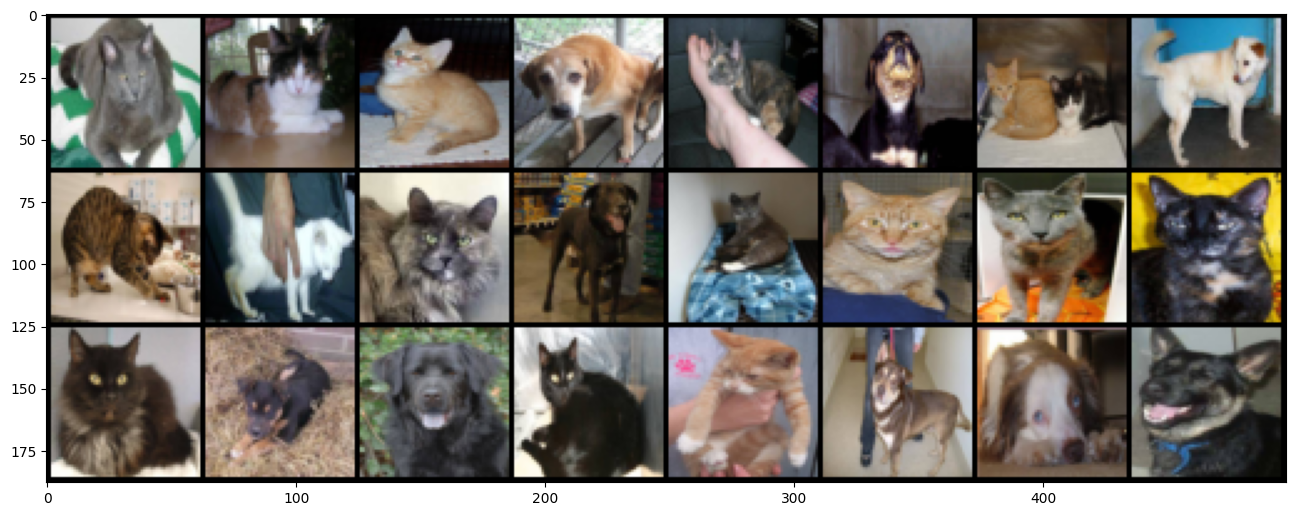

In [ ]:
samples, labels = next(iter(train_dataset))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()

plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

**Now we build our Model**

We will use the ```nn.Sequential``` method to construct our model. Alernatively we can use the functional module, however this is simpler and more similar to styles you'll work with in Keras.

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(3,16,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
        ) 
            
    self.conv2 =   nn.Sequential(
        nn.Conv2d(16,32,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
      ) 
    
    self.conv3 =   nn.Sequential(
        nn.Conv2d(32,64,3),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
      ) 
    
    self.fc1 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(64*5*5,256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU()
    )
            
    self.fc2 = nn.Sequential(
    nn.Linear(128,2),
    )
                
  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return F.softmax(x,dim = 1) 

### **Using TorchSummary to display a Keras style summary output**

`summary(your_model, input_size=(channels, H, W))`

In [ ]:
model = CNN()
model.cuda()
summary(model,(3,60,60))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 58, 58]             448
              ReLU-2           [-1, 16, 58, 58]               0
         MaxPool2d-3           [-1, 16, 29, 29]               0
            Conv2d-4           [-1, 32, 27, 27]           4,640
              ReLU-5           [-1, 32, 27, 27]               0
         MaxPool2d-6           [-1, 32, 13, 13]               0
            Conv2d-7           [-1, 64, 11, 11]          18,496
              ReLU-8           [-1, 64, 11, 11]               0
         MaxPool2d-9             [-1, 64, 5, 5]               0
          Flatten-10                 [-1, 1600]               0
           Linear-11                  [-1, 256]         409,856
             ReLU-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
             ReLU-14                  [

### **Defining a Loss Function and Optimizer**

We need to define what type of loss we'll be using and what method will be using to update the gradients.
1. We use Cross Entropy Loss 
2. We use the Adam Optimization Descent Algorithm - we also specify a learn rate (LR) of 0.0005.
3. Set our epochs to 50

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimiser = optim.Adam(model.parameters(),lr=0.0005)
epochs = 10

## **Train our Model**

**We use TQDM to perform a keras style training**


In [ ]:
type(train_dataset)

torch.utils.data.dataloader.DataLoader

In [ ]:
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(epochs):
  model.train()
  total = 0
  correct = 0
  counter = 0
  train_running_loss = 0

  # Set our unit for tqdm and number of iterations i.e. len(train_dataset) no need for len as train_dataset is an iteratable
  # tepoch becomes 
  with tqdm(train_dataset, unit="batch") as tepoch:
    # our progress bar labels
    tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

    for data,label in tepoch:
      data,label = data.to(device), label.to(device)
      optimiser.zero_grad()
      output = model(data)
      loss = criterion(output,label)
      loss.backward()
      optimiser.step() 

      train_running_loss += loss.item() * data.size(0)

      _, pred = torch.max(output.data, 1)

      # Keep track of how many images have been foward propagated
      total += label.size(0)
      # Keep track of how many were predicted to be correct
      correct += (pred == label).sum().item()

    train_accuracy.append(correct/total)
    train_loss.append(train_running_loss/len(train_dataset))
    print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
    print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

  # Get our validation accuracy and loss scores
  if epoch %1 == 0:
    model.eval()
    total = 0
    correct = 0
    val_running_loss = 0

    # We don't need gradients for validation, so wrap in  no_grad to save memory
    with torch.no_grad():
      for val_data, val_label in val_dataset:
        val_data, val_label = val_data.to(device), val_label.to(device)
        val_output = model(val_data)
        loss_val = criterion(val_output, val_label)

        # Calacuate the running loss by multiplying loss value by batch size
        val_running_loss += loss_val.item() * val_data.size(0)
        _, pred = torch.max(val_output.data, 1)    
        total += val_label.size(0)
        correct += (pred == val_label).sum().item()

      val_accuracy.append(correct/total)
      # Calcuate loss per epoch by dividing runing loss by number of items in validation set
      val_loss.append(val_running_loss/len(val_dataset))

      print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
      print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(val_dataset)}')

<ipython-input-21-332676b384b0>:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  with tqdm(train_dataset, unit="batch") as tepoch:


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 1 Training Accuracy = 0.59445
Epoch 1 Training Loss = 21.081430807495117
Epoch 1 Validation Accuracy = 0.6722
Epoch 1 Validation Loss = 19.628758630934794


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6962
Epoch 2 Training Loss = 19.060334718322753
Epoch 2 Validation Accuracy = 0.6904
Epoch 2 Validation Loss = 18.962712363832317


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.73045
Epoch 3 Training Loss = 18.028840924072266
Epoch 3 Validation Accuracy = 0.7408
Epoch 3 Validation Loss = 17.740860437891286


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.75345
Epoch 4 Training Loss = 17.43736868286133
Epoch 4 Validation Accuracy = 0.7404
Epoch 4 Validation Loss = 17.639617303374468


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.77335
Epoch 5 Training Loss = 16.892576289367675
Epoch 5 Validation Accuracy = 0.752
Epoch 5 Validation Loss = 17.39972097251066


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.7819
Epoch 6 Training Loss = 16.60398597564697
Epoch 6 Validation Accuracy = 0.7692
Epoch 6 Validation Loss = 16.888244045767813


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8024
Epoch 7 Training Loss = 16.082511988830568
Epoch 7 Validation Accuracy = 0.7658
Epoch 7 Validation Loss = 16.97483481115596


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.8086
Epoch 8 Training Loss = 15.88828497314453
Epoch 8 Validation Accuracy = 0.772
Epoch 8 Validation Loss = 16.848691211384573


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8158
Epoch 9 Training Loss = 15.650232522583007
Epoch 9 Validation Accuracy = 0.7728
Epoch 9 Validation Loss = 16.758763273810125


  0%|          | 0/625 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.82625
Epoch 10 Training Loss = 15.294161988830567
Epoch 10 Validation Accuracy = 0.7604
Epoch 10 Validation Loss = 17.153810440355045


In [ ]:
train_loss

[21.081430807495117,
 19.060334718322753,
 18.028840924072266,
 17.43736868286133,
 16.892576289367675,
 16.60398597564697,
 16.082511988830568,
 15.88828497314453,
 15.650232522583007,
 15.294161988830567]

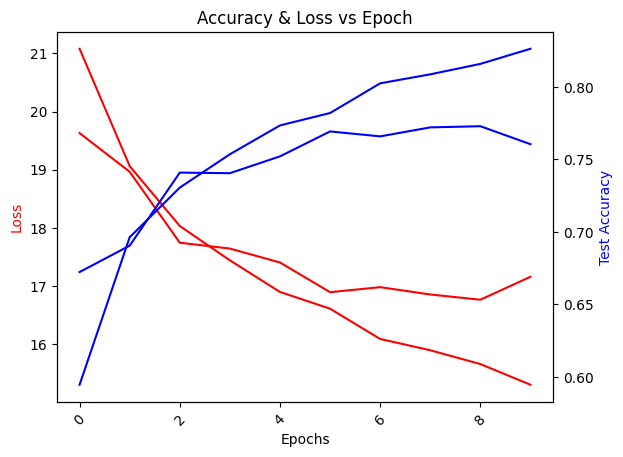

In [ ]:
epoch_log = [*range(epochs)]

fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, train_loss, 'r-')
ax2.plot(epoch_log, train_accuracy, 'b-')

ax1.plot(epoch_log, val_loss, 'r-')
ax2.plot(epoch_log, val_accuracy, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='r')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

In [ ]:
PATH = './cats_vs_dogs_10_epochs.pth'
torch.save(model.state_dict(), PATH)

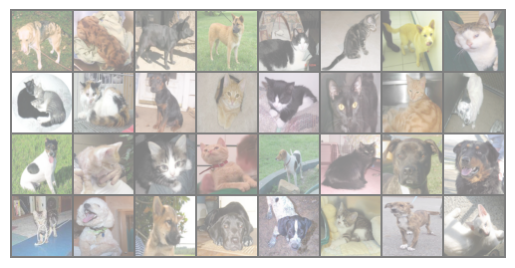

GroundTruth:  1 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 


In [ ]:
# function to show an image
def imshow(img):
  img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis('off')
  plt.show()

# Loading one mini-batch
dataiter = iter(val_dataset)
images, labels = next(dataiter)

# Display images using torchvision's utils.make_grid()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ',''.join('%1s ' % labels[j].numpy() for j in range(32)))

In [ ]:
# Create an instance of the model and move it (memory and operations) to the CUDA device.
model = CNN()
model.to(device)

# Load weights from the specified path
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

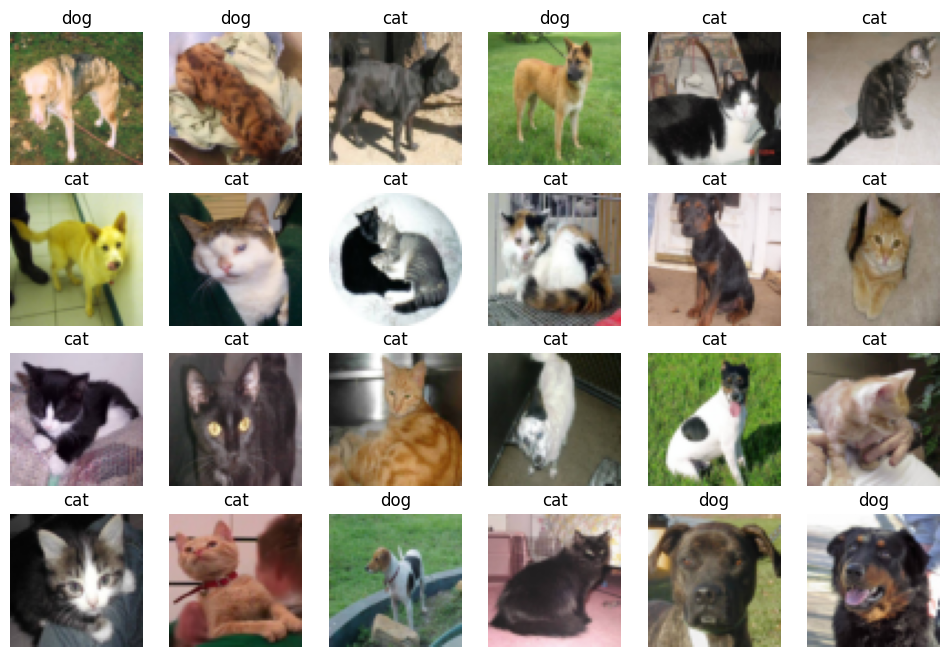

In [ ]:
samples, _ = next(iter(val_dataset))
samples = samples.to(device)

fig = plt.figure(figsize=(12, 8))
fig.tight_layout()

output = model(samples[:24])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}

for num, sample in enumerate(samples[:24]):
  plt.subplot(4,6,num+1)
  plt.title(ad[pred[num]])
  plt.axis('off')
  sample = sample.cpu().numpy()
  plt.imshow(np.transpose(sample, (1,2,0)))